# Predicting Hourly Energy Consumption

In [59]:
import warnings
warnings.simplefilter(action='ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()

**Load Dataset & Set Datetime as Index**

In [60]:
df = pd.read_csv('energy_usage_hourly/PJME_hourly.csv')
df.set_index('Datetime', inplace=True)
df.index = pd.to_datetime(df.index)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [61]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


<Axes: title={'center': 'PJME Energy Use in MW'}, xlabel='Datetime'>

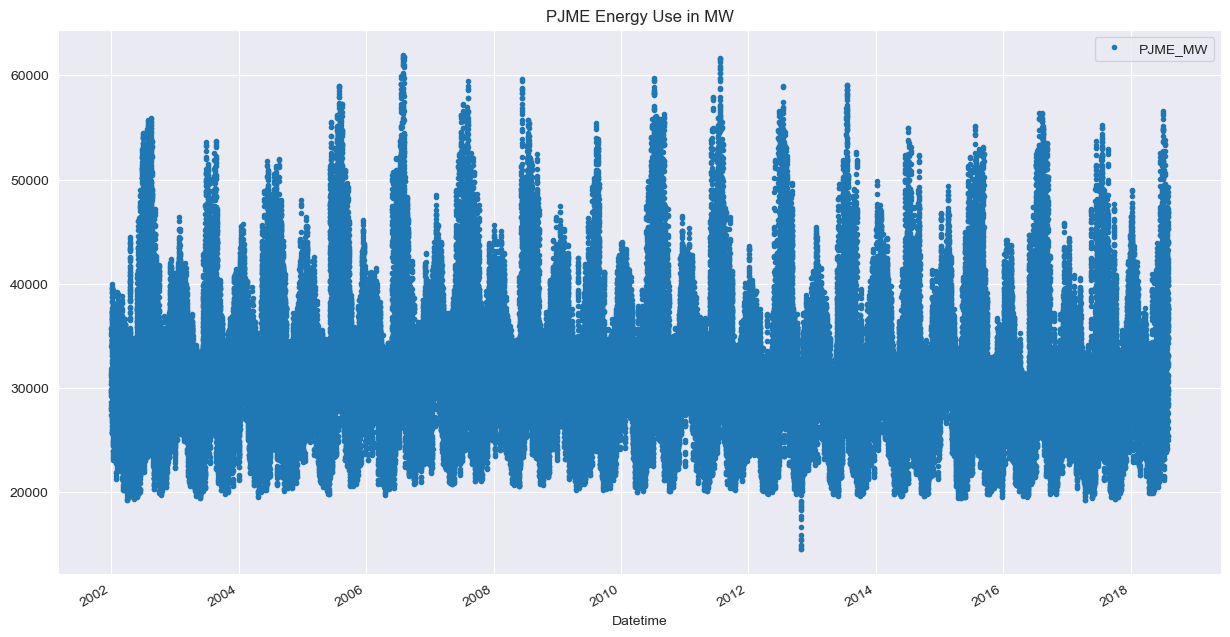

In [62]:
df.plot(style='.', figsize=(15, 8),
        color=color_pal[0],
        title='PJME Energy Use in MW')

**Train / Test Split**

In [63]:
train = df.loc[df.index < '2015-01-01']
test = df.loc[df.index >= '2015-01-01']

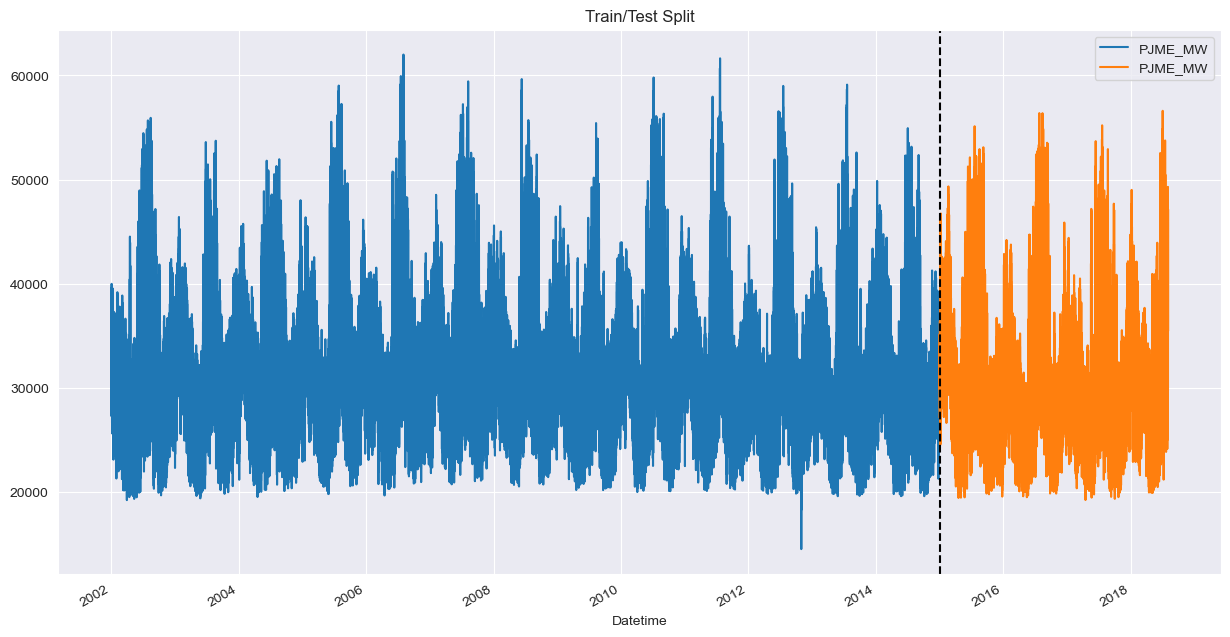

In [64]:
fig, ax = plt.subplots(figsize=(15, 8))
train.plot(ax=ax, label='Train')
test.plot(ax=ax, label='Test')
plt.axvline('2015-01-01', color='black', ls='--')
plt.title('Train/Test Split')
plt.show()

<Axes: xlabel='Datetime'>

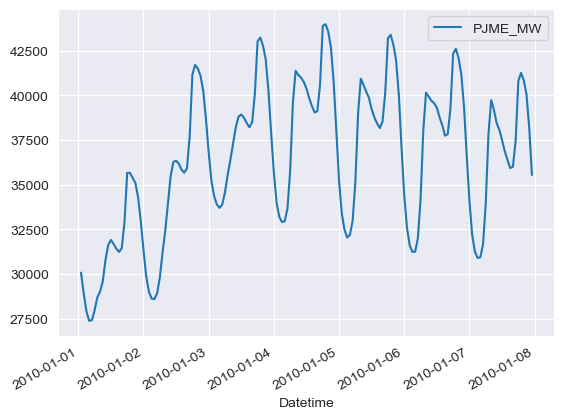

In [65]:
df.loc[(df.index > '2010-01-01') & (df.index < '2010-01-08')].plot()

**Feature Creation**

In [66]:
def create_features(df):
        """
        :param df: Dataframe to create new datetime-based features
        :return: New dataframe including more features for time series
        """
        df = df.copy()
        df['hour'] = df.index.hour
        df['day_of_week'] = df.index.dayofweek
        df['quarter'] = df.index.quarter
        df['month'] = df.index.month
        df['year'] = df.index.year
        df['dayofyear'] = df.index.dayofyear
        return df

In [67]:
df = create_features(df)
df.head()

,PJME_MW,hour,day_of_week,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


In [68]:
train = create_features(train)
test = create_features(test)

train.head()

,PJME_MW,hour,day_of_week,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


**Visualize Feature to Target Relationship**

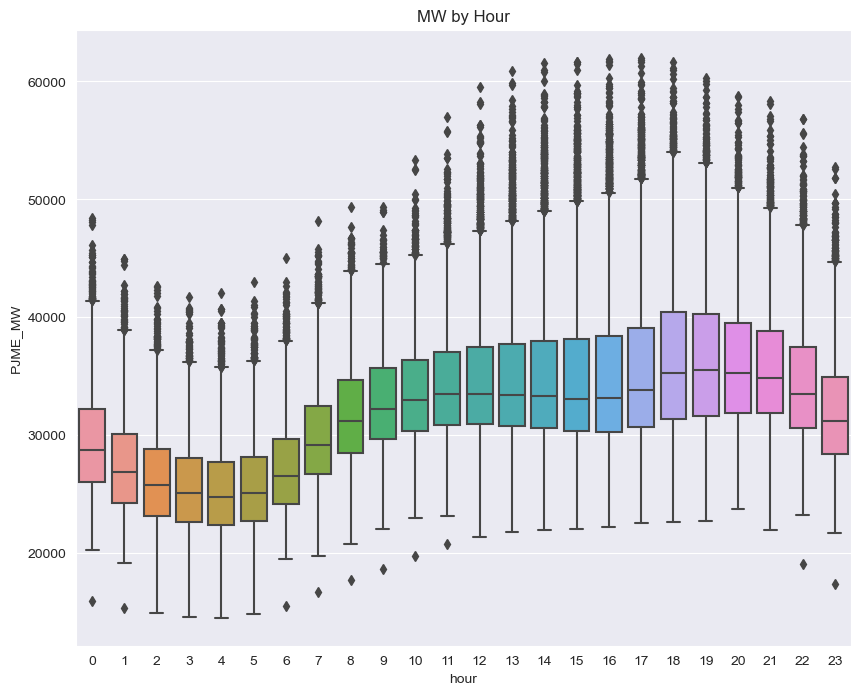

In [69]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

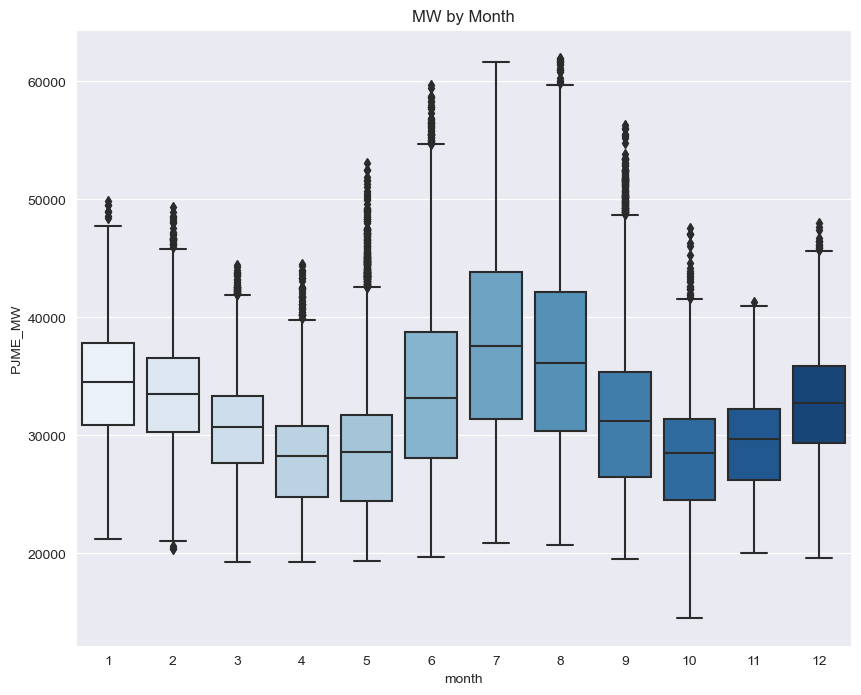

In [70]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

**Create XGB Model**

In [71]:
features = df.columns[1:]
target = df.columns[0]

print(features)
print(target)

Index(['hour', 'day_of_week', 'quarter', 'month', 'year', 'dayofyear'], dtype='object')
PJME_MW


In [72]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [75]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:23192.08347	validation_1-rmse:22262.72116
[59]	validation_0-rmse:1940.87501	validation_1-rmse:4242.86606


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

**Feature Importance**

In [76]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])

fi

,importance
hour,0.400626
day_of_week,0.090241
quarter,0.022528
month,0.335743
year,0.031681
dayofyear,0.119180


<Axes: title={'center': 'Feature Importance'}>

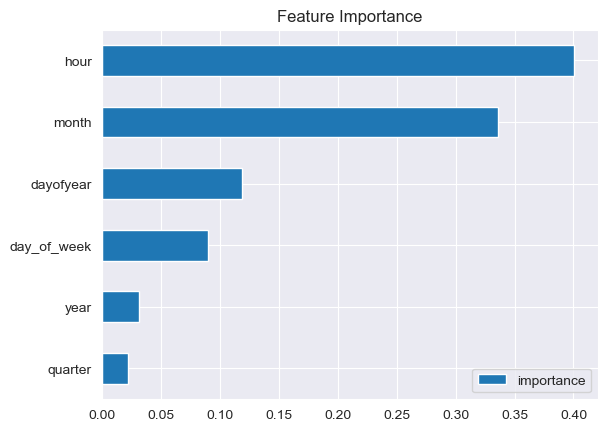

In [79]:
fi.sort_values(by='importance').plot.barh(title='Feature Importance')#.invert_yaxis()

**Predict Test Set**

In [80]:
test['prediction'] = reg.predict(X_test)

In [81]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
df.tail()

,PJME_MW,hour,day_of_week,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,40108.804688
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,40108.804688
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,38110.726562
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,34509.949219
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,33253.828125


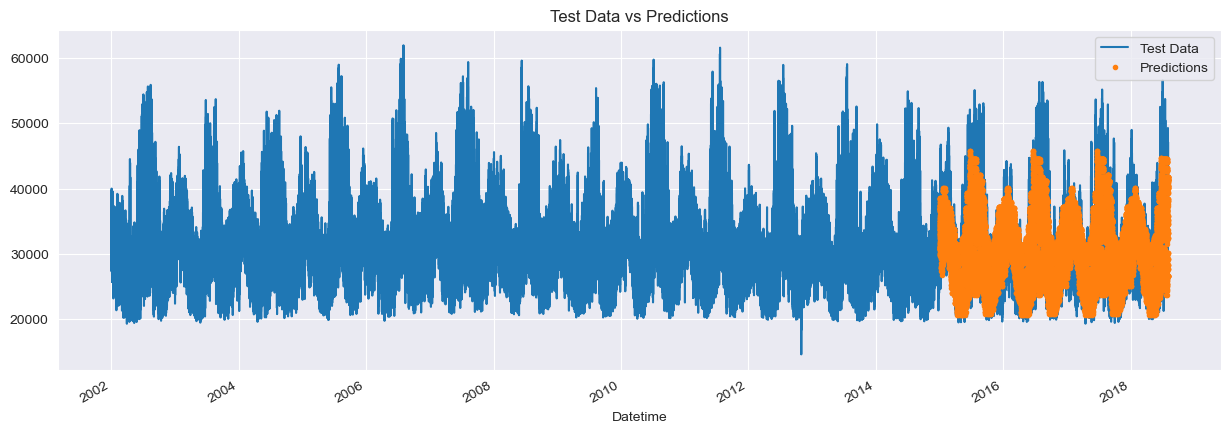

In [82]:
ax = df['PJME_MW'].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Test Data', 'Predictions'])
ax.set_title('Test Data vs Predictions')
plt.show()

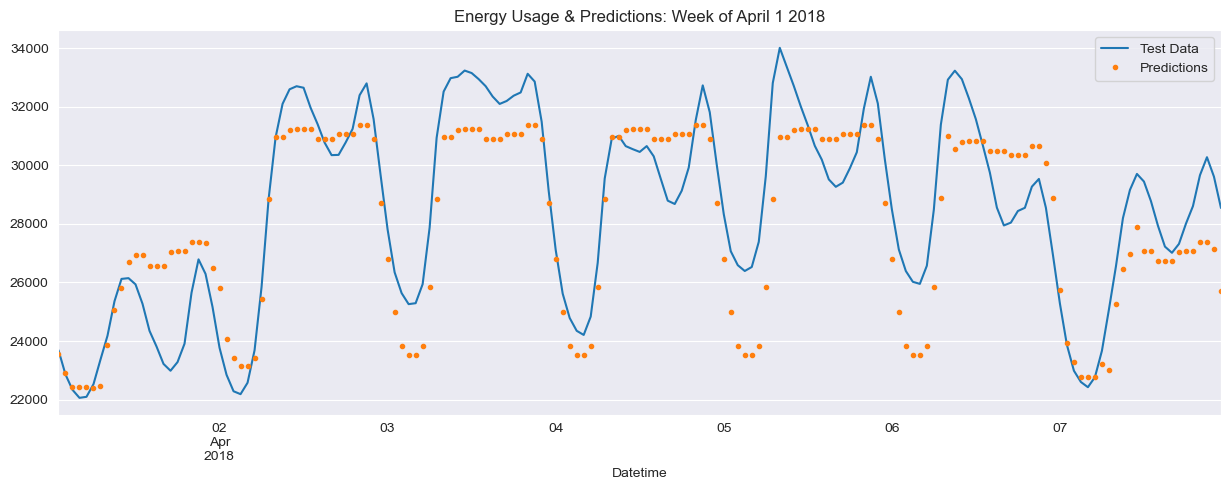

In [83]:
ax = df.loc[(df.index > '2018-04-01') & (df.index < '2018-04-08')]['PJME_MW'].plot(figsize=(15,5))
df.loc[(df.index > '2018-04-01') & (df.index < '2018-04-08')]['prediction'].plot(style='.')
plt.legend(['Test Data', 'Predictions'])
plt.title('Energy Usage & Predictions: Week of April 1 2018')
plt.show()

In [84]:
mean_squared_error(y_test, test['prediction'])

14162822.721131425

In [87]:
score = mean_squared_error(y_test, test['prediction'], squared=False)
print(f'RMSE Score on Test Set: {score: .2f}')

RMSE Score on Test Set:  3763.35


**Calculate Errors**

In [91]:
test['residuals'] = abs(y_test - test['prediction'])
test['residuals'].head()

Datetime
2015-01-01 00:00:00     377.212891
2015-12-31 01:00:00    3272.238281
2015-12-31 02:00:00    4059.144531
2015-12-31 03:00:00    4256.021484
2015-12-31 04:00:00    4440.021484
Name: residuals, dtype: float64

In [92]:
test['date'] = test.index.date
test.head()

,PJME_MW,hour,day_of_week,quarter,month,year,dayofyear,prediction,date,residuals
Datetime,,,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1,32424.787109,2015-01-01,377.212891
2015-12-31 01:00:00,24305.0,1,3,4,12,2015,365,27577.238281,2015-12-31,3272.238281
2015-12-31 02:00:00,23156.0,2,3,4,12,2015,365,27215.144531,2015-12-31,4059.144531
2015-12-31 03:00:00,22514.0,3,3,4,12,2015,365,26770.021484,2015-12-31,4256.021484
2015-12-31 04:00:00,22330.0,4,3,4,12,2015,365,26770.021484,2015-12-31,4440.021484


**Days with Least Errors**

In [96]:
test.groupby(by='date')['residuals'].agg(np.mean).sort_values().head()

date
2017-04-22    428.334717
2016-09-27    455.130859
2018-05-19    458.394450
2016-04-04    461.127523
2017-05-06    468.640055
Name: residuals, dtype: float64

**Days with Most Errors**

In [97]:
test.groupby(by='date')['residuals'].agg(np.mean).sort_values().tail()

date
2015-02-20    10935.253174
2016-09-09    11385.571289
2016-09-10    13042.321940
2016-08-14    13533.325846
2016-08-13    14026.037760
Name: residuals, dtype: float64

**Next Steps**

* More robust validation
* Add more features (weather forecast, holidays)